# Урок 6. Градиентный бустинг

В этом уроке мы продолжаем тему ансамблей алгоритмов, рассматривая еще один их вид - _градиентный бустинг_. 

Вспоминая тему предыдущего урока, случайные леса, напомним, что случайный лес - это ансамбль деревьев небольшой глубины, строящихся независимо друг от друга. В независимости построения деревьев кроется и плюс и минус алгоритма: с одной стороны, построение деревьев можно распараллеливать и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что для решения сложных задач требуется очень большое количество деревьев. В этих случаях случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

Бустинг является своеобразным решением этой проблемы: он заключается в последовательном построении ансамбля, когда деревья строятся одно за другим, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

## Алгоритм градиентного бустинга (GBM)

Итоговый алгоритм ищется в виде взвешенной суммы базовых алгоритмов (обратите внимание: не среднего, а суммы):

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

В случае регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно вначале обучить первый простой алгоритм:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

Как мы помним, такая задача легко решается методом градиентного спуска.

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N-1)})^{2},$$ 

$$s_{i}^{(N-1)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

In [1]:
# задача регрессии
import numpy as np

y_true = np.array([35, 50, 65])

In [2]:
# 1 base: mean(y)
y_pred_1 = [np.mean(y_true)] * len(y_true)
print('y_pred1 =\t', np.array(y_pred_1))
s_1 = y_true - y_pred_1
print('bias_1 =\t', s_1)
y_pred_ensemble = y_pred_1 
print('y_ensemble =\t', y_pred_ensemble)

y_pred1 =	 [50. 50. 50.]
bias_1 =	 [-15.   0.  15.]
y_ensemble =	 [50.0, 50.0, 50.0]


In [3]:
# 2 tree: mean(y_pred_2 - s_1)**2 -> min
y_pred_2 = np.array([-10, -1, 7])
s_2 = s_1 - y_pred_2 # = y_true - y_pred_1 - y_pred_2
print('bias_2 =\t', s_2)
y_pred_ensemble = y_pred_1 + y_pred_2
print('y_ensemble =\t', y_pred_ensemble)

bias_2 =	 [-5.  1.  8.]
y_ensemble =	 [40. 49. 57.]


In [4]:
# 3 tree: mean(y_pred_3 - s_2)**2 -> min
y_pred_3 = np.array([-2, 2, 10])
s_3 = s_2 - y_pred_3 # = y_true - y_pred_1 - y_pred_2 - y_pred_3
print('bias_3 =\t', s_3)
y_pred_ensemble = y_pred_1 + y_pred_2 + y_pred_3
print('y_ensemble =\t', y_pred_ensemble)
print('y_true =\t', np.array(y_true, dtype='float'))

bias_3 =	 [-3. -1. -2.]
y_ensemble =	 [38. 51. 67.]
y_true =	 [35. 50. 65.]


Выбор сдвига из условия $s_{i} = y_{i} - a_{N}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исходной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Коэффициент $\gamma$ для найденного алгоритма также находится по аналогии с наискорейшим градиентным спуском:

$$\gamma_{N} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{N-1}(x_{i}) + \gamma b_{N}(x_{i})).$$

Обычно в качестве функции потерь в задачах регрессии принимается квадратичная функция потерь ($L_{2}$ loss):

$$L(y, z) = (y-z)^{2},$$

его производная по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y-z|,$$

его производная по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь:

$$L(y, z) = log(1 + exp(-yz))$$

ее производная:

$$L'(y, z) = \frac{y}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s_{i}$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta \gamma_{N} b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

В конечном итоге алгоритм построения модели градиентного бустинга заключается в следующих шагах:

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

находится оптимальный коэффициент $\gamma$

$$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i})).$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционно)

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [63]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [64]:
from sklearn.datasets import load_diabetes

In [65]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [66]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [136]:
new_x=X_train[:2,:]
new_x

array([[-0.00551455, -0.04464164,  0.04229559,  0.04941532,  0.02457414,
        -0.02386057,  0.07441156, -0.03949338,  0.05228   ,  0.02791705],
       [ 0.06350368, -0.04464164, -0.05039625,  0.10794412,  0.03145391,
         0.01935392, -0.01762938,  0.02360753,  0.05803913,  0.04034337]])

In [100]:
X_train.shape[0]

331

In [131]:
np.take(X_train,[0,1], axis=0, out=None, mode='raise')

array([[-0.00551455, -0.04464164,  0.04229559,  0.04941532,  0.02457414,
        -0.02386057,  0.07441156, -0.03949338,  0.05228   ,  0.02791705],
       [ 0.06350368, -0.04464164, -0.05039625,  0.10794412,  0.03145391,
         0.01935392, -0.01762938,  0.02360753,  0.05803913,  0.04034337]])

Напишем функцию, реализующую предсказание в градиентном бустинге.


$$a_{N}(x) = \sum^{N}_{n=1}\eta\gamma_{n}b_{n}(x).$$

In [67]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [68]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [69]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [70]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [71]:
# Число деревьев в ансамбле
#n_trees = 10

# для простоты примем коэффициенты равными 1
#coefs = [1] * n_trees

# Максимальная глубина деревьев
#max_depth = 3

# Шаг
#eta = 0.5

#trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [72]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

### Задание 1

In [93]:
def showerr_tnumbers(num_trees:list, max_depth=2, eta=0.5):
    """
    This function draws graphs of the train and test errors depending on the number of trees 
    in the gradient boosting algorithm
    
    """
    #plt.figure(figsize=(12,8))
    for i in range(len(num_trees)):
        n_trees=num_trees[i]
        coefs=[1] * n_trees
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)
    
        plt.xlabel('Iteration number')
        plt.ylabel('MSE')
        plt.xlim(0, n_trees)
        plt.plot(list(range(1, n_trees+1)), train_errors, label='train error')
        plt.plot(list(range(1, n_trees+1)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.title(f"Number of trees = {n_trees}")
        plt.show()

Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 2483
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 3275


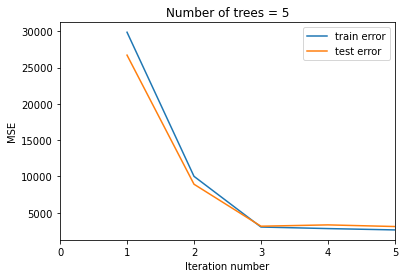

Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 1916
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 3731


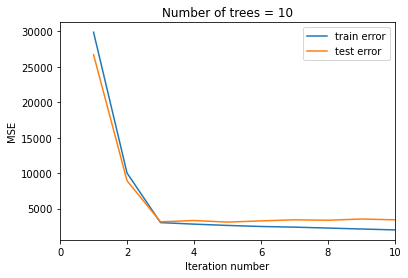

Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 1152
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 4197


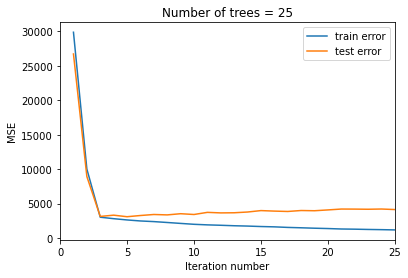

In [57]:
a=[5,10,25]
showerr_tnumbers(a)


С увеличением количества деревьев, при прочих равных и после 3 итераций наблюдаем: 1) ярковыраженное уменьшение ошибки на тренировочной выборке, 2) ярковыраженное увеличение ошибки на тестовой выборке, 3) соответственно увеличение разности ошибок между тренировочной и тестовой выборками, что может свидетельствовать о переобучении модели.

При этом наблюдается интерсная закономерность - излом на графике (в районе 3) остается постоянным. Может ли это говорить об оптимальном количестве деревьев? 

In [83]:
def showerr_tnumbers_etas(num_trees:list, etas:list, max_depth=2):
    """
    This function draws graphs of the train and test errors depending on the number of trees 
    in the gradient boosting algorithm
    
    """
    #plt.figure(figsize=(12,8))
    for i in range(len(num_trees)):
        n_trees=num_trees[i]
        coefs=[1] * n_trees
        for j in range (len(etas)):
            eta=etas[j]
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)

            plt.xlabel('Iteration number')
            plt.ylabel('MSE')
            plt.xlim(0, n_trees)
            plt.plot(list(range(1, n_trees+1)), train_errors, label='train error')
            plt.plot(list(range(1, n_trees+1)), test_errors, label='test error')
            plt.legend(loc='upper right')
            plt.title(f"N trees = {n_trees}, eta={eta}")
            plt.show()

Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 2815
Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 3324


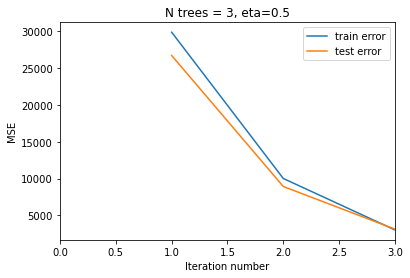

Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.05 на тренировочной выборке: 19053
Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.05 на тестовой выборке: 16824


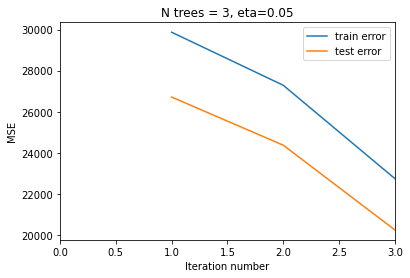

Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.005 на тренировочной выборке: 28570
Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.005 на тестовой выборке: 25535


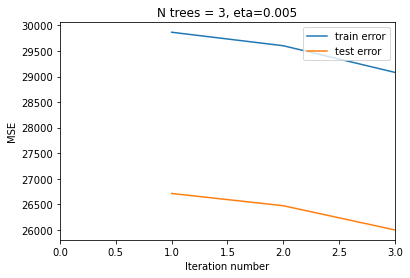

In [84]:
b=[3]
etas=[0.5, 0.05, 0.005]

showerr_tnumbers_etas(b,etas)

Вывод: С уменьшнием шага градиента алгоритм учится медленнее

In [85]:
def showerr_tnumbers_etas_depths(num_trees:list, etas:list, depths:list):
    """
    This function draws graphs of the train and test errors depending on the number of trees 
    in the gradient boosting algorithm
    
    """
    #plt.figure(figsize=(12,8))
    for i in range(len(num_trees)):
        n_trees=num_trees[i]
        coefs=[1] * n_trees
        for j in range(len(etas)):
            eta=etas[j]
            for k in range(len (depths)):
                max_depth=depths[k]
                trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
                evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)

                plt.xlabel('Iteration number')
                plt.ylabel('MSE')
                plt.xlim(0, n_trees)
                plt.plot(list(range(1, n_trees+1)), train_errors, label='train error')
                plt.plot(list(range(1, n_trees+1)), test_errors, label='test error')
                plt.legend(loc='upper right')
                plt.title(f"N trees = {n_trees}, eta={eta}, m_depth = {max_depth}")
                plt.show()


Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 2815
Ошибка алгоритма из 3 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 3324


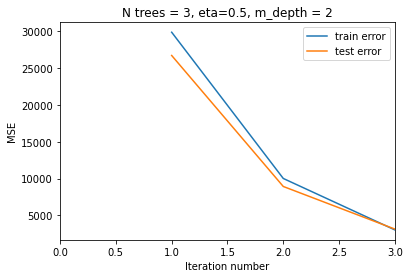

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 2089
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3563


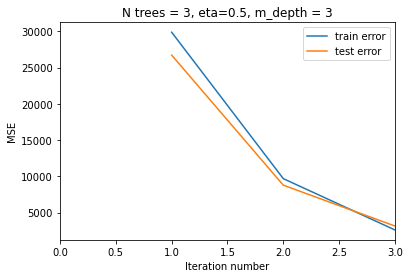

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.5 на тренировочной выборке: 1077
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.5 на тестовой выборке: 3698


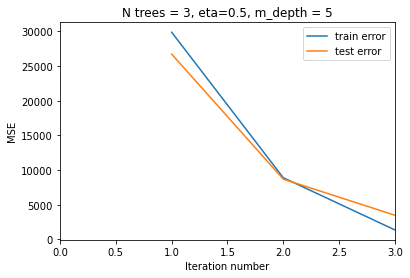

In [86]:
t=[3]
e=[0.5]
d=[2,3,5]

showerr_tnumbers_etas_depths(t,e,d)

Вывод: С увеличением глубины деревьев, наблюдается тот же эффект, что и при увеличении их количества, т.е. наблюдается эффект переобучения

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 2089
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 3563


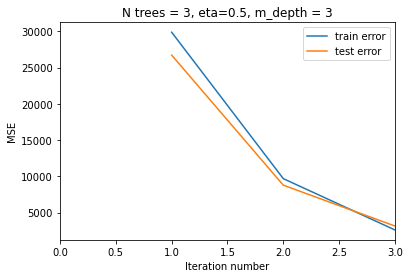

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 18856
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 16860


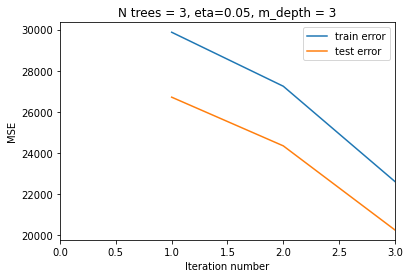

In [87]:
tt=[3]
ee=[0.5, 0.05]
dd=[3]

showerr_tnumbers_etas_depths(tt,ee,dd)

В качестве оптимальных параметров предлагаю: кол-во деревьев -3, eta - 0.5, глубина - 3

### Задание 2

In [95]:
import random

# Generate 10 unique random numbers within a range
num_list = random.sample(range(0, 1000), 10)
print(num_list)

[595, 653, 635, 706, 625, 335, 417, 284, 253, 966]


In [140]:
def gb_st_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, s_num=20):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        
        num_list = random.sample(range(0, X_train.shape[0]), s_num)
        new_X_train=np.take(X_train,num_list, axis=0, out=None, mode='raise')
        new_y_train=np.take(y_train, num_list, axis=0, out=None, mode='raise')
        # Создаём случайную выборку из тренингово сета размером s_num x X_train.shape[1]
        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(new_X_train, new_y_train)
            
            train_errors.append(mean_squared_error(new_y_train, gb_predict(new_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(new_X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(new_X_train, bias(new_y_train, z_train))
            
            train_errors.append(mean_squared_error(new_y_train, gb_predict(new_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [141]:
def showerr_tnumbers_1(num_trees:list, max_depth=2, eta=0.5):
    """
    This function draws graphs of the train and test errors depending on the number of trees 
    in the gradient boosting algorithm
    
    """
    #plt.figure(figsize=(12,8))
    for i in range(len(num_trees)):
        n_trees=num_trees[i]
        coefs=[1] * n_trees
        trees, train_errors, test_errors = gb_st_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth)
    
        plt.xlabel('Iteration number')
        plt.ylabel('MSE')
        plt.xlim(0, n_trees)
        plt.plot(list(range(1, n_trees+1)), train_errors, label='train error')
        plt.plot(list(range(1, n_trees+1)), test_errors, label='test error')
        plt.legend(loc='upper right')
        plt.title(f"Number of trees = {n_trees}")
        plt.show()

Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 15086
Ошибка алгоритма из 5 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 13489


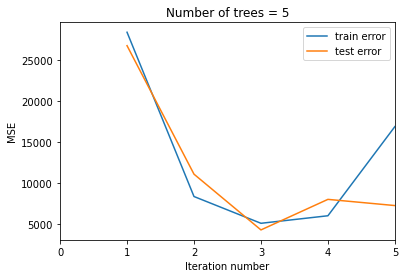

Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 38921
Ошибка алгоритма из 10 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 48136


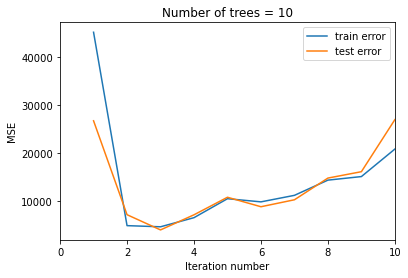

Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.5 на тренировочной выборке: 243897
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.5 на тестовой выборке: 315746


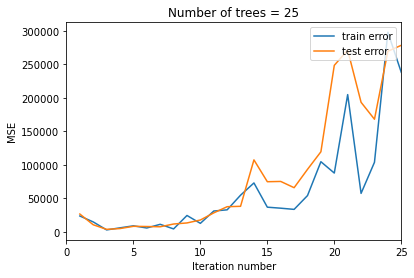

In [142]:
aaa=[5,10,25]
showerr_tnumbers_1(aaa)

График стохастической версии сильно отличается от обычной. Уже не видно чёткой разницы между ошибками обучения и тестирования с увеличением кол-ва деревьев, при этом алгоритм обучается ощутимо быстрее, оч интересно))

In [ ]:
n_trees = 15
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [ ]:
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.005.

In [ ]:
eta = 0.005

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.05 и попробуем увеличить глубину деревьев

In [ ]:
eta = 0.05
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [ ]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

In [ ]:
get_error_plot(n_trees, train_errors, test_errors)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)

## Домашние задания

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.